<a href="https://colab.research.google.com/github/vvamsi91/RTML_AS1/blob/main/RTML_AS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import os
import pickle


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def load_cifar10_batch(file):
    # Load a batch from a CIFAR-10 file
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def load_cifar10_data(data_dir):
    # Load training data and labels from multiple batches
    train_data, train_labels = zip(*(load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}')).values() for i in range(1, 6)))

    # Concatenate training data and labels
    train_data, train_labels = np.concatenate(train_data), np.concatenate(train_labels)

    # Load test data and labels
    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch')).values()

    return train_data, train_labels, test_data, test_labels

In [5]:
class MLP(nn.Module):
    def __init__(self):
        # Initialize a multi-layer perceptron with specified layers
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            # Input layer: 32 * 32 * 3 features to 512 neurons
            nn.Linear(32 * 32 * 3, 512),
            # Apply ReLU activation function
            nn.ReLU(),
            # Hidden layer 1: 512 neurons to 256 neurons
            nn.Linear(512, 256),
            # Apply ReLU activation function
            nn.ReLU(),
            # Hidden layer 2: 256 neurons to 128 neurons
            nn.Linear(256, 128),
            # Apply ReLU activation function
            nn.ReLU(),
            # Output layer: 128 neurons to 10 neurons (for 10 classes)
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # Reshape input tensor to (batch_size, 32 * 32 * 3) and pass through layers
        return self.layers(x.view(-1, 32 * 32 * 3))

In [7]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00
time: 312 µs (started: 2024-02-02 17:24:41 +00:00)


In [8]:
torch.manual_seed(123)


time: 6.1 ms (started: 2024-02-02 17:24:51 +00:00)


In [13]:
cifar10 = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))


time: 624 ms (started: 2024-02-02 17:36:24 +00:00)


In [17]:
cifar10_val = datasets.CIFAR10('./data', train=False, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))


time: 532 ms (started: 2024-02-02 17:37:12 +00:00)


In [22]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean, std = imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)

Files already downloaded and verified
time: 14.2 s (started: 2024-02-02 17:37:30 +00:00)


In [23]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

time: 974 µs (started: 2024-02-02 17:37:46 +00:00)


epoch -  0  Train Loss -  [1.6803072088434388]  Train Accuracy -  [40.106]  Validation Loss -  [1.5766524807713664]  Validation Accuracy -  [43.46]
epoch -  1  Train Loss -  [1.6803072088434388, 1.4761747907387166]  Train Accuracy -  [40.106, 47.768]  Validation Loss -  [1.5766524807713664, 1.4963916646786772]  Validation Accuracy -  [43.46, 46.63]
epoch -  2  Train Loss -  [1.6803072088434388, 1.4761747907387166, 1.3731357899905015]  Train Accuracy -  [40.106, 47.768, 51.262]  Validation Loss -  [1.5766524807713664, 1.4963916646786772, 1.411019206999209]  Validation Accuracy -  [43.46, 46.63, 50.45]
epoch -  3  Train Loss -  [1.6803072088434388, 1.4761747907387166, 1.3731357899905015, 1.2919373693408223]  Train Accuracy -  [40.106, 47.768, 51.262, 54.166]  Validation Loss -  [1.5766524807713664, 1.4963916646786772, 1.411019206999209, 1.4075842440699617]  Validation Accuracy -  [43.46, 46.63, 50.45, 50.52]
epoch -  4  Train Loss -  [1.6803072088434388, 1.4761747907387166, 1.37313578999

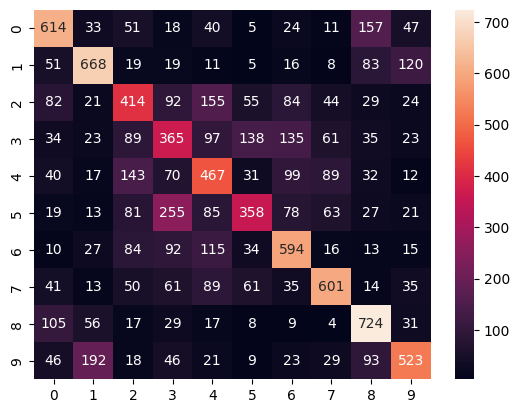

time: 14min 29s (started: 2024-02-02 17:46:51 +00:00)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(test_loader))
    val_accuracy.append(100 * correct / total)
    print("epoch - ", epoch, " Train Loss - ", train_loss, " Train Accuracy - ", train_accuracy, " Validation Loss - ", val_loss, " Validation Accuracy - ", val_accuracy)

# Evaluate the model
y_pred, y_true = [], []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')

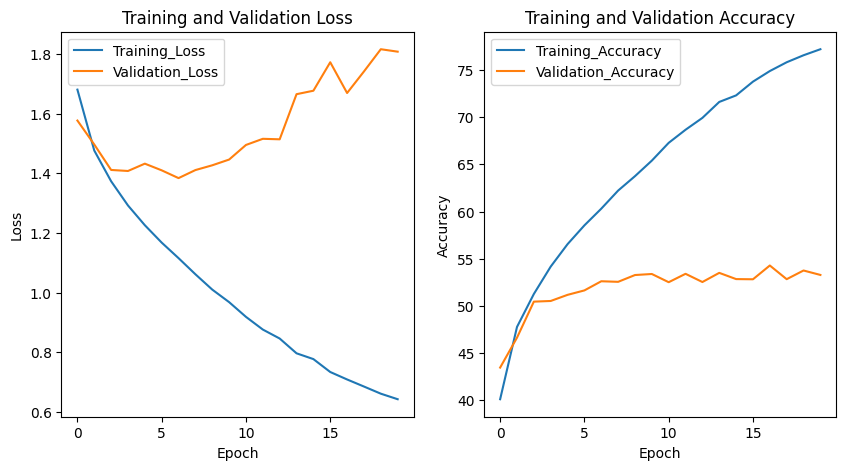

time: 640 ms (started: 2024-02-02 18:06:39 +00:00)


In [31]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training_Loss')
plt.plot(val_loss, label='Validation_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training_Accuracy')
plt.plot(val_accuracy, label='Validation_Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.show()

In [32]:
class MLP_extended(nn.Module):
    def __init__(self):
        super(MLP_extended, self).__init__()

        # Define the layers with increased width and additional layers
        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 1024),  # Increased width
            nn.ReLU(),
            nn.Linear(1024, 512),  # Increased width
            nn.ReLU(),
            nn.Linear(512, 256),  # Increased width
            nn.ReLU(),
            nn.Linear(256, 128),  # Increased width
            nn.ReLU(),
            nn.Linear(128, 64),  # Additional layer
            nn.ReLU(),
            nn.Linear(64, 10)  # Additional layer, output matches the number of classes
        )

    def forward(self, x):
        # Reshape input tensor and pass through the layers
        return self.layers(x.view(-1, 32 * 32 * 3))

time: 1.21 ms (started: 2024-02-02 18:08:25 +00:00)


In [33]:
# Load CIFAR-10 data and transform it
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root=cifar10_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=cifar10_dir, train=False, download=True, transform=transform)

# Create DataLoader instances for training and testing
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 74743692.40it/s]


Extracting https://raw.githubusercontent.com/vvamsi91/RTML_AS1/main/house-train.csv/cifar-10-python.tar.gz to https://raw.githubusercontent.com/vvamsi91/RTML_AS1/main/house-train.csv
Files already downloaded and verified
time: 7.87 s (started: 2024-02-02 18:14:58 +00:00)


epoch -  0  Train Loss -  [1.7464679683870672]  Train Accuracy -  [37.296]  Validation Loss -  [1.578979970543248]  Validation Accuracy -  [43.47]
epoch -  1  Train Loss -  [1.7464679683870672, 1.4961429191062519]  Train Accuracy -  [37.296, 47.116]  Validation Loss -  [1.578979970543248, 1.440555594529316]  Validation Accuracy -  [43.47, 49.12]
epoch -  2  Train Loss -  [1.7464679683870672, 1.4961429191062519, 1.365739870940328]  Train Accuracy -  [37.296, 47.116, 51.658]  Validation Loss -  [1.578979970543248, 1.440555594529316, 1.3982108201190924]  Validation Accuracy -  [43.47, 49.12, 50.62]
epoch -  3  Train Loss -  [1.7464679683870672, 1.4961429191062519, 1.365739870940328, 1.2644940399757736]  Train Accuracy -  [37.296, 47.116, 51.658, 55.132]  Validation Loss -  [1.578979970543248, 1.440555594529316, 1.3982108201190924, 1.3736639971945697]  Validation Accuracy -  [43.47, 49.12, 50.62, 51.65]
epoch -  4  Train Loss -  [1.7464679683870672, 1.4961429191062519, 1.365739870940328, 1

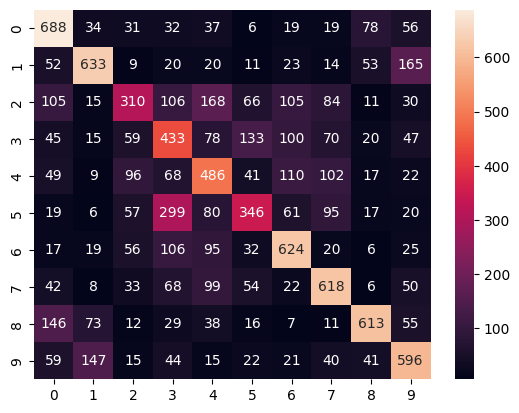

time: 18min 50s (started: 2024-02-02 18:19:45 +00:00)


In [35]:


# Initialize model, criterion, and optimizer
model = MLP_extended().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(testloader))
    val_accuracy.append(100 * correct / total)
    print("epoch - ", epoch, " Train Loss - ", train_loss, " Train Accuracy - ", train_accuracy, " Validation Loss - ", val_loss, " Validation Accuracy - ", val_accuracy)


# Evaluate the model
y_pred, y_true = [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

time: 27.2 ms (started: 2024-02-02 18:39:24 +00:00)


In [37]:
data = pd.read_csv('https://raw.githubusercontent.com/vvamsi91/RTML_AS1/main/house-train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


time: 275 ms (started: 2024-02-02 18:41:51 +00:00)


In [43]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP(len(useful_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


time: 3.86 ms (started: 2024-02-02 18:52:45 +00:00)


<ipython-input-44-809ced1c60e4>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_prepro = data[useful_cols + [target_col]].copy().fillna(data.mean())


Epoch 1/100, Train Loss: 196226.3484, Val Loss: 196708.8734
Epoch 2/100, Train Loss: 196500.0557, Val Loss: 196652.5297
Epoch 3/100, Train Loss: 195990.0152, Val Loss: 196346.3453
Epoch 4/100, Train Loss: 195642.9785, Val Loss: 195284.4813
Epoch 5/100, Train Loss: 193331.0194, Val Loss: 192560.3281
Epoch 6/100, Train Loss: 190206.4818, Val Loss: 186949.9328
Epoch 7/100, Train Loss: 181953.3560, Val Loss: 176750.3266
Epoch 8/100, Train Loss: 168604.5621, Val Loss: 160230.7141
Epoch 9/100, Train Loss: 148926.1919, Val Loss: 136519.4211
Epoch 10/100, Train Loss: 123016.6609, Val Loss: 106806.4539
Epoch 11/100, Train Loss: 96306.1453, Val Loss: 80618.1754
Epoch 12/100, Train Loss: 80789.7721, Val Loss: 70950.3770
Epoch 13/100, Train Loss: 76153.9646, Val Loss: 67892.6379
Epoch 14/100, Train Loss: 73921.8464, Val Loss: 66249.4367
Epoch 15/100, Train Loss: 72494.1107, Val Loss: 64201.7137
Epoch 16/100, Train Loss: 70465.0858, Val Loss: 62785.0031
Epoch 17/100, Train Loss: 68898.0386, Val Los

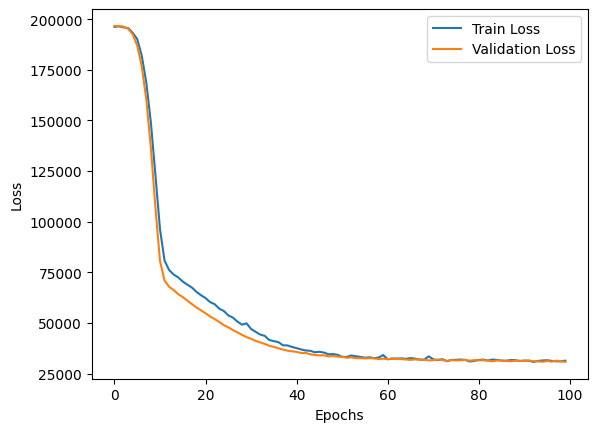

Total parameters: 11905
time: 9.07 s (started: 2024-02-02 18:52:47 +00:00)


In [44]:


# Define useful columns and preprocess the dataset
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF']
target_col = 'SalePrice'

# Preprocess the dataset
data_prepro = data[useful_cols + [target_col]].copy().fillna(data.mean())

# Split dataset into features and target
X, y = data_prepro[useful_cols], data_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors and create data loaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                         torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)),
                          batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                                       torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)),
                        batch_size=32, shuffle=False)

# Define and initialize MLP model, criterion, and optimizer
model = MLP(len(useful_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs, train_losses, val_losses = 100, [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        rmse_loss = torch.sqrt(criterion(output, y_batch))  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    y_pred = []
    y_true = []
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            total_val_loss += torch.sqrt(criterion(output, y_batch)).item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Evaluate the model
mse, rmse, r2 = mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred)**0.5, r2_score(y_true, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print total parameters and save the model
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')


In [57]:
# Define useful columns and target column
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

# Select columns for training and preprocessing
df_train_prepro = data[useful_cols + [target_col]].copy()

# Identify numeric and categorical columns
numeric_cols = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

# Fill missing values for numeric columns with mean and for categorical columns with mode
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())
df_train_prepro[categorical_cols] = df_train_prepro[categorical_cols].fillna(df_train_prepro[categorical_cols].mode().iloc[0])

# One-hot encoding for categorical features
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_cols)

# Split dataset into features and target
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]


time: 72 ms (started: 2024-02-02 19:36:48 +00:00)


In [60]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors and create data loaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                         torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)),
                          batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                                       torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)),
                        batch_size=64, shuffle=False)

# Define and initialize MLP model, criterion, and optimizer
model = MLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs, train_losses, val_losses = 100, [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Evaluate the model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5

print(f'\nRMSE: {rmse}\n')

# Print total parameters and save the model
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')


Epoch 1/100, Train Loss: 197041.5461, Val Loss: 199341.6094
Epoch 2/100, Train Loss: 198196.3051, Val Loss: 199333.8031
Epoch 3/100, Train Loss: 195845.6012, Val Loss: 199297.2875
Epoch 4/100, Train Loss: 196213.8668, Val Loss: 199170.9906
Epoch 5/100, Train Loss: 196980.4005, Val Loss: 198828.5531
Epoch 6/100, Train Loss: 195826.0839, Val Loss: 198053.4937
Epoch 7/100, Train Loss: 194500.6283, Val Loss: 196529.9406
Epoch 8/100, Train Loss: 193455.9655, Val Loss: 193892.5812
Epoch 9/100, Train Loss: 189398.5691, Val Loss: 189541.6437
Epoch 10/100, Train Loss: 184483.9178, Val Loss: 182974.9688
Epoch 11/100, Train Loss: 176933.4194, Val Loss: 173716.3813
Epoch 12/100, Train Loss: 166276.0296, Val Loss: 161162.9188
Epoch 13/100, Train Loss: 153508.6349, Val Loss: 145519.4781
Epoch 14/100, Train Loss: 137660.7278, Val Loss: 127717.5391
Epoch 15/100, Train Loss: 122485.0000, Val Loss: 110506.5922
Epoch 16/100, Train Loss: 106942.5720, Val Loss: 98374.8734
Epoch 17/100, Train Loss: 99609.08

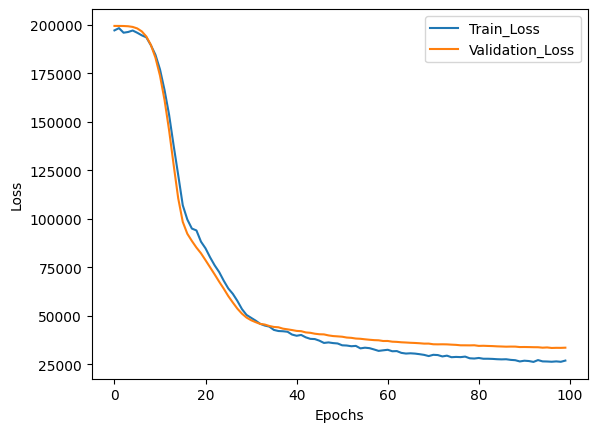

time: 630 ms (started: 2024-02-02 19:43:35 +00:00)


In [61]:
# Plot training and validation loss
plt.plot(train_losses, label='Train_Loss')
plt.plot(val_losses, label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:

# Define and initialize the extended MLP model
class ComplexMLP(nn.Module):
    def __init__(self, input_size):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc9 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.fc9(x)
        return x

time: 1.92 ms (started: 2024-02-02 19:56:13 +00:00)


In [66]:
input_size = X_train_scaled.shape[1]
model = ComplexMLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs, train_losses, val_losses = 100, [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5

print(f'RMSE: {rmse}\n')


Epoch 1/100, Train Loss: 197435.4613, Val Loss: 199060.6000
Epoch 2/100, Train Loss: 189290.4227, Val Loss: 149693.3531
Epoch 3/100, Train Loss: 76486.9914, Val Loss: 46730.1445
Epoch 4/100, Train Loss: 40349.0641, Val Loss: 36257.6414
Epoch 5/100, Train Loss: 30324.4873, Val Loss: 33731.6613
Epoch 6/100, Train Loss: 28351.5076, Val Loss: 32080.6293
Epoch 7/100, Train Loss: 26438.3330, Val Loss: 32843.3469
Epoch 8/100, Train Loss: 25007.8363, Val Loss: 31041.8363
Epoch 9/100, Train Loss: 23636.4938, Val Loss: 31478.6461
Epoch 10/100, Train Loss: 23627.3513, Val Loss: 32035.9984
Epoch 11/100, Train Loss: 23177.7120, Val Loss: 30872.2812
Epoch 12/100, Train Loss: 21494.9562, Val Loss: 29977.7590
Epoch 13/100, Train Loss: 20701.1612, Val Loss: 34748.5398
Epoch 14/100, Train Loss: 22662.1876, Val Loss: 30618.6926
Epoch 15/100, Train Loss: 20096.2449, Val Loss: 33421.1234
Epoch 16/100, Train Loss: 21597.1080, Val Loss: 31777.3281
Epoch 17/100, Train Loss: 19718.4718, Val Loss: 31091.4027
Ep

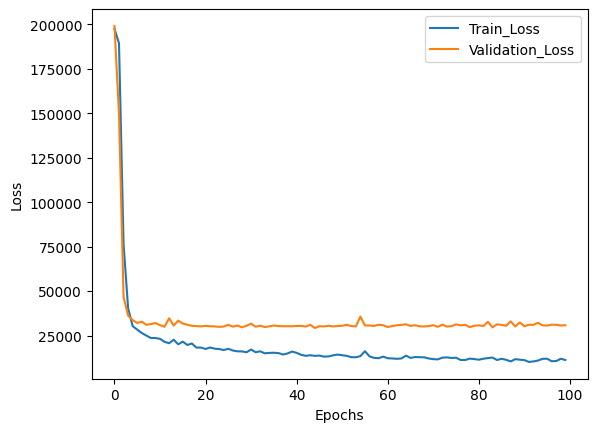

time: 241 ms (started: 2024-02-02 19:59:24 +00:00)


In [67]:
plt.plot(train_losses, label='Train_Loss')
plt.plot(val_losses, label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()